In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('data/df_final.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25848 entries, 0 to 25847
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   address                 25848 non-null  object 
 1   city                    25848 non-null  object 
 2   state                   25848 non-null  object 
 3   postcode                25848 non-null  int64  
 4   latitude                25848 non-null  float64
 5   longitude               25848 non-null  float64
 6   bedroom_number          25848 non-null  int64  
 7   bathroom_number         25848 non-null  int64  
 8   square_meter            25848 non-null  int64  
 9   price                   25848 non-null  int64  
 10  household_number        25848 non-null  int64  
 11  household_mean_income   25848 non-null  int64  
 12  families_number         25848 non-null  int64  
 13  family_mean_income      25848 non-null  int64  
 14  non_family_number       25848 non-null

In [4]:
corr_matrix = df.corr()
corr_matrix['price'].sort_values(ascending = False)

C:\Users\ottableaudeveloper2\AppData\Local\Temp\ipykernel_13200\3579065146.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


price                     1.000000
non_family_mean_income    0.418229
household_mean_income     0.366494
square_meter              0.361733
bathroom_number           0.349462
postcode                  0.330218
family_mean_income        0.296516
bedroom_number            0.234776
median_age                0.080463
25to34                    0.024043
non_family_number        -0.003537
35to44                   -0.003749
45to54                   -0.011441
55to59                   -0.044175
household_number         -0.046922
75to84                   -0.054811
population               -0.057003
65to74                   -0.059573
60to64                   -0.065549
families_number          -0.075762
20to24                   -0.089294
latitude                 -0.101964
longitude                -0.315682
Name: price, dtype: float64

In [5]:
columns_to_drop = ['household_mean_income', 'family_mean_income','25to34', 'non_family_number','35to44', 'families_number',
                   'non_family_number', '45to54', '55to59', 'household_number', '75to84', '65to74', '60to64', '20to24', 'median_age']
df.drop(columns = columns_to_drop, axis = 1, inplace = True)

In [6]:
df.rename(columns={'non_family_mean_income': 'income', 'address':'street'}, inplace = True)

### Correlation

In [7]:
corr_matrix = df.corr()
corr_matrix['price'].sort_values(ascending = False)

C:\Users\ottableaudeveloper2\AppData\Local\Temp\ipykernel_13200\3579065146.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


price              1.000000
income             0.418229
square_meter       0.361733
bathroom_number    0.349462
postcode           0.330218
bedroom_number     0.234776
population        -0.057003
latitude          -0.101964
longitude         -0.315682
Name: price, dtype: float64

In [8]:
df['income_cat'] = pd.cut(df['income'], bins= [30000., 50000, 60000, 80000, 100000., np.inf], labels = [1,2,3,4,5])

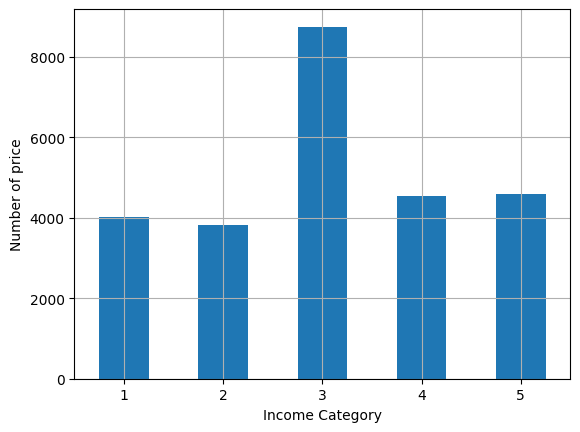

In [9]:
df['income_cat'].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel('Income Category')
plt.ylabel('Number of price')
plt.show()

In [10]:
df = df.dropna()

In [11]:
strat_train_set, strat_test_set = train_test_split(df, test_size = 0.2, stratify = df["income_cat"],random_state=42)

In [12]:
strat_train_set["income_cat"].value_counts() / len(strat_test_set)

3    1.360739
5    0.712342
4    0.707483
1    0.623712
2    0.595530
Name: income_cat, dtype: float64

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

In [14]:
df = strat_train_set.copy()

In [15]:
df

,street,city,state,postcode,latitude,longitude,bedroom_number,bathroom_number,square_meter,price,income,population
10363,Overland Avenue,Culver City,CA,90230,34.008440,-118.396230,2,2,89,689000,79946,33620
9263,Beaver Street,Sylmar,CA,91342,34.307690,-118.434670,3,2,106,450000,54344,92764
18243,Northwest at Pickwick - W - NS,Dallas,TX,75225,32.865765,-96.800400,1,1,76,325000,112602,21703
8641,Sea Cliff Way,Oceanside,CA,92056,33.200554,-117.308430,1,1,72,499950,69345,54045
13692,North Ridge Loop East,Eagle Mountain,UT,84005,40.363460,-111.978300,3,2,113,350000,80703,42222
...,...,...,...,...,...,...,...,...,...,...,...,...
13983,Rae Court,Buena Vista,CO,81211,38.834846,-106.149010,2,2,115,420000,45069,8156
1611,Admiralty Way,Lynnwood,WA,98087,47.861767,-122.275314,1,1,53,269999,81068,41958
7844,Wisteria Drive,Palm Desert,CA,92211,33.765380,-116.325874,3,3,151,699000,64192,26106
3545,South Kihei Road,Kihei,HI,96753,20.761880,-156.458300,1,1,60,938000,83478,29547


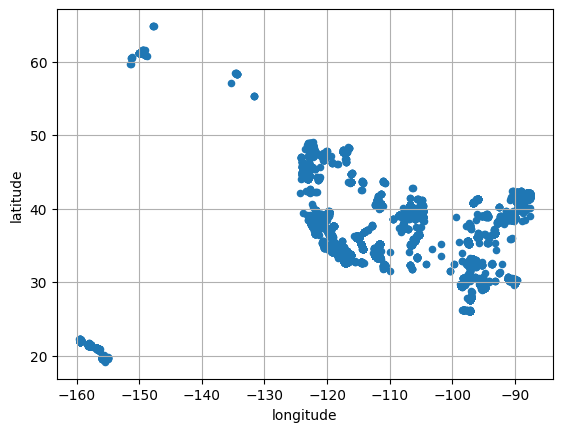

In [16]:
df.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True)
plt.show()

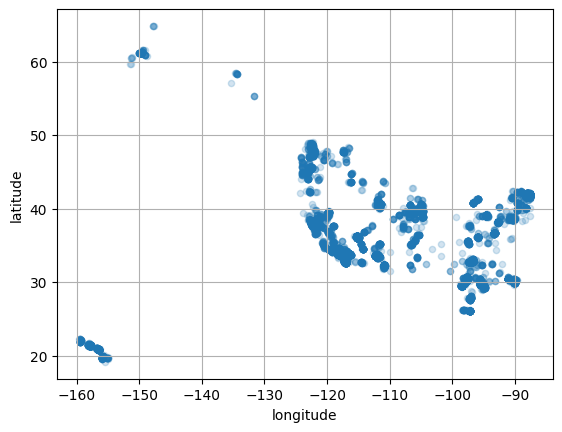

In [17]:
df.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, alpha = 0.2)
plt.show()

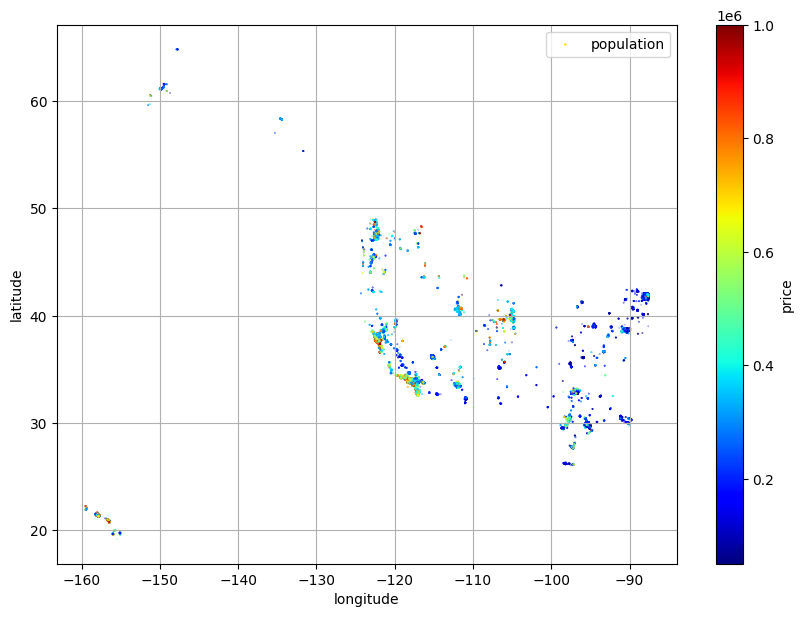

In [18]:
df.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, s = df["population"] / 100000,
        label = "population", c = "price", cmap = "jet", colorbar = True, legend=True, sharex=False,
        figsize=(10, 7))
plt.show()

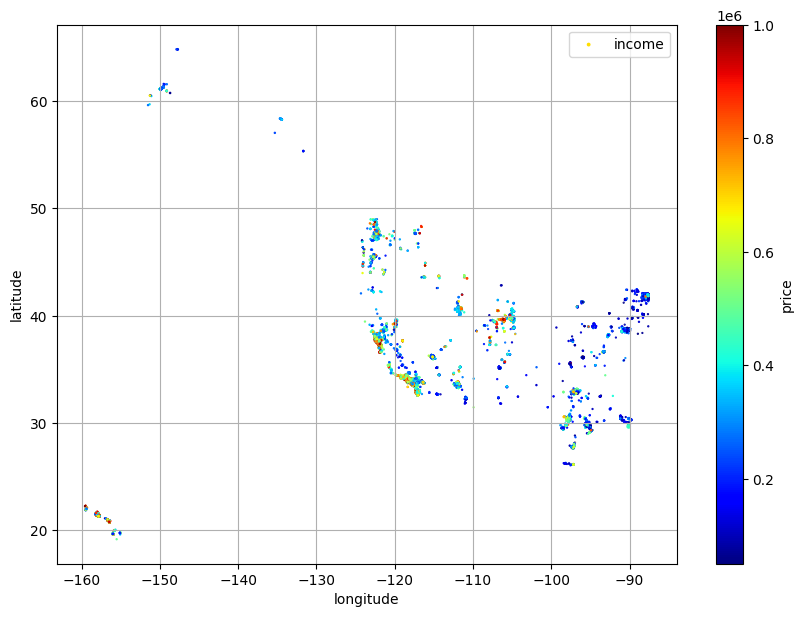

In [19]:
df.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, s = df["income"] / 100000,
        label = "income", c = "price", cmap = "jet", colorbar = True, legend=True, sharex=False,
        figsize=(10, 7))
plt.show()

In [20]:
corr_matrix = df.corr()
corr_matrix["price"].sort_values(ascending=False)

C:\Users\ottableaudeveloper2\AppData\Local\Temp\ipykernel_13200\1388606898.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


price              1.000000
income             0.415499
square_meter       0.363863
bathroom_number    0.346882
postcode           0.328013
bedroom_number     0.236784
population        -0.054857
latitude          -0.100782
longitude         -0.313823
Name: price, dtype: float64

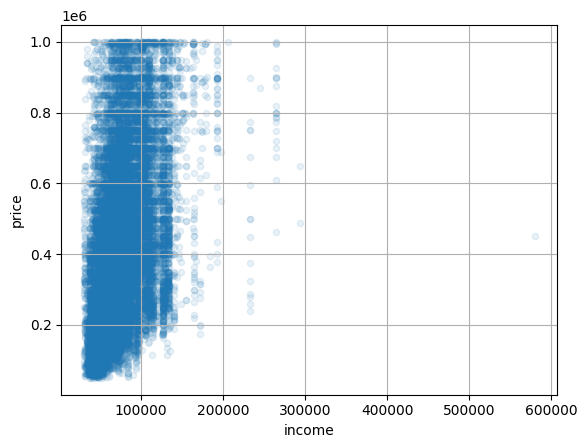

In [21]:
df.plot(kind = "scatter", x = "income", y = "price", alpha = 0.1, grid = True)
plt.show()

### Algorithm

In [22]:
df = strat_train_set.drop('price', axis = 1)
df_labels = strat_train_set['price'].copy()

In [23]:
df_num = df.select_dtypes(include=[np.number])

In [24]:
df_cat_state = df[['state']]
df_cat_city = df[['city']]
df_cat_street = df[['street']]

In [25]:
cat_encoder = OneHotEncoder()
df_state_1hot = cat_encoder.fit_transform(df_cat_state)
df_city_1hot = cat_encoder.fit_transform(df_cat_city)
df_street_1hot = cat_encoder.fit_transform(df_cat_street)

In [26]:
cat_encoder.categories_

[array(['(7364) Boulder Ave & 2nd St NB', '10 Mile Circle', '100 South',
        ..., 'ʻOlohana Street', 'ʻĀinamakua Drive', 'ʻŌhua Avenue'],
       dtype=object)]

In [27]:
df_state_1hot

<20579x21 sparse matrix of type '<class 'numpy.float64'>'
	with 20579 stored elements in Compressed Sparse Row format>

In [28]:
df_city_1hot

<20579x1179 sparse matrix of type '<class 'numpy.float64'>'
	with 20579 stored elements in Compressed Sparse Row format>

In [29]:
df_street_1hot

<20579x9029 sparse matrix of type '<class 'numpy.float64'>'
	with 20579 stored elements in Compressed Sparse Row format>

In [30]:
std_scaler = StandardScaler()
df_num_std_scaled = std_scaler.fit_transform(df_num)

In [31]:
num_pipeline = make_pipeline(StandardScaler())

In [32]:
df

,street,city,state,postcode,latitude,longitude,bedroom_number,bathroom_number,square_meter,income,population
10363,Overland Avenue,Culver City,CA,90230,34.008440,-118.396230,2,2,89,79946,33620
9263,Beaver Street,Sylmar,CA,91342,34.307690,-118.434670,3,2,106,54344,92764
18243,Northwest at Pickwick - W - NS,Dallas,TX,75225,32.865765,-96.800400,1,1,76,112602,21703
8641,Sea Cliff Way,Oceanside,CA,92056,33.200554,-117.308430,1,1,72,69345,54045
13692,North Ridge Loop East,Eagle Mountain,UT,84005,40.363460,-111.978300,3,2,113,80703,42222
...,...,...,...,...,...,...,...,...,...,...,...
13983,Rae Court,Buena Vista,CO,81211,38.834846,-106.149010,2,2,115,45069,8156
1611,Admiralty Way,Lynnwood,WA,98087,47.861767,-122.275314,1,1,53,81068,41958
7844,Wisteria Drive,Palm Desert,CA,92211,33.765380,-116.325874,3,3,151,64192,26106
3545,South Kihei Road,Kihei,HI,96753,20.761880,-156.458300,1,1,60,83478,29547


In [33]:
num_attribs = ['postcode', 'latitude', 'longitude', 'bedroom_number', 'bathroom_number', 'square_meter', 'income', 'population']
cat_attribs = ['street', 'city', 'state']

cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown = 'ignore'))

# preprocessing = ColumnTransformer([
#     ('num', num_pipeline, num_attribs),
#     ('cat', cat_pipeline, cat_attribs)
# ])

In [34]:
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include = np.number)),
    (cat_pipeline, make_column_selector(dtype_include = object))
)

In [35]:
df_prepared = preprocessing.fit_transform(df)

In [36]:
df_prepared.shape

(20579, 10237)

In [37]:
preprocessing.get_feature_names_out()

array(['pipeline-1__postcode', 'pipeline-1__latitude',
       'pipeline-1__longitude', ..., 'pipeline-2__state_UT',
       'pipeline-2__state_WA', 'pipeline-2__state_WY'], dtype=object)

### Model Training

In [38]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(df, df_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002359F275B80>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002359F275B20>)])),
                ('linearregression', LinearRegression())])

In [39]:
df_predictions = lin_reg.predict(df)
df_predictions[:5].round(2)

array([663549.94, 450066.44, 234487.59, 468653.41, 350013.72])

In [40]:
df_labels.iloc[:5].values

array([689000, 450000, 325000, 499950, 350000], dtype=int64)

In [41]:
lin_rmse = mean_squared_error(df_labels, df_predictions, squared = False)

In [42]:
lin_rmse

64888.61073261316

In [43]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(df, df_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002359F275B80>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002359F275B20>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [44]:
df_predictions = tree_reg.predict(df)
tree_rmse = mean_squared_error(df_labels, df_predictions, squared = False)

In [45]:
tree_rmse

13881.579777623645

In [46]:
tree_rmses = -cross_val_score(tree_reg, df, df_labels, scoring = 'neg_root_mean_squared_error', cv = 10)

In [47]:
pd.Series(tree_rmses).describe()

count        10.000000
mean     118315.125644
std        3889.588906
min      111973.166005
25%      116205.429530
50%      117483.763150
75%      121271.521306
max      123740.955774
dtype: float64

In [48]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state = 42))
forest_rmses = -cross_val_score(forest_reg, df, df_labels, scoring = 'neg_root_mean_squared_error', cv = 10)

In [51]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     91210.267952
std       2964.634171
min      85943.713876
25%      89579.444070
50%      90847.919301
75%      93872.318973
max      95323.629827
dtype: float64

In [54]:
# full_pipeline = make_pipeline([
#     ('preprocessing', preprocessing),
#     ('random_forest', RandomForestRegressor(random_state = 42)),
# ])
#
# param_grid = [
#     {'preprocessing_geo_n_clusters': [5, 8, 10],
#      'random_forest_max_features': [4, 6, 8]},
#     {'preprocessing_geo_n_clusters': [10, 15],
#      'random_forest_max_features': [6, 8, 10]},
# ]
#
# grid_search = GridSearchCV(full_pipeline, param_grid, cv = 3, scoring = 'neg_root_mean_squared_error')
# grid_search.fit(df, df_labels)

ValueError: Invalid parameter 'preprocessing_geo_n_clusters' for estimator Pipeline(steps=[('list',
                 [('preprocessing',
                   ColumnTransformer(transformers=[('pipeline-1',
                                                    Pipeline(steps=[('standardscaler',
                                                                     StandardScaler())]),
                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000235A55D4AF0>),
                                                   ('pipeline-2',
                                                    Pipeline(steps=[('onehotencoder',
                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000235A55D40D0>)])),
                  ('random_forest', RandomForestRegressor(random_state=42))])]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
# df_predictions = tree_reg.predict(df)
# tree_rmse = mean_squared_error(df_labels, df_predictions, squared = False)

In [62]:
X_test = strat_test_set.drop('price', axis = 1)
y_test = strat_test_set['price'].copy()

In [63]:
final_predictions = tree_reg.predict(X_test)

In [64]:
final_rmse = mean_squared_error(y_test, final_predictions, squared = False)

In [65]:
final_rmse

115306.17773652195

In [67]:
joblib.dump(tree_reg, 'model/remax_poc.pkl')

['remax_poc.pkl']